<div style="text-align: center;">
    <h1>Elderly Action Recognition Challenge</h1>
    <h2>Dataset Preparation with FiftyOne</h2>
</div>

This notebook walks you through the process of preparing a dataset for the [Elderly Action Recognition Challenge](https://voxel51.com/computer-vision-events/elderly-action-recognition-challenge-wacv-2025). It covers essential steps such as importing data, parsing actions, assigning categories, splitting videos into clips, and exporting the dataset using [FiftyOne](https://docs.voxel51.com/).

---

**Useful Links:**
- [Challenge Overview](https://voxel51.com/computer-vision-events/elderly-action-recognition-challenge-wacv-2025/)
- [Submission Page](https://eval.ai/web/challenges/challenge-page/2427/overview)

---

<div style="text-align: center;">
    <img src="https://github.com/user-attachments/assets/a97ed6ff-8aa8-4911-98b0-6f8dce36ab83" alt="challenge-logo" width="200" style="margin-right: 20px;">
    <img src="https://github.com/user-attachments/assets/6b1d05e4-3da3-4591-b70f-764e5ad0e5da" alt="fiftyone-logo" width="200">
</div>

---

**Goal**: Enable participants to work with the dataset efficiently and submit meaningful solutions to the challenge, ultimately advancing the field of action recognition for the elderly.


## Requirements anf FiftyOne Installation

First thing you need to do is create a Python environment in your system, if you are not familiar with that please take a look of this [ReadmeFile](https://github.com/voxel51/fiftyone-examples?tab=readme-ov-file#-prerequisites-for-beginners-), where we will explain how to create the environment. After that be sure you activate the created environment and install FiftyOne there.

In [ ]:
#!pip install fiftyone

## Imports
In this section, we import all the necessary libraries and modules to work with the dataset, including FiftyOne, pandas, and re for regular expressions. These libraries provide the foundation for loading, processing, and interacting with the dataset.

In [1]:
import os
import fiftyone as fo
import fiftyone.types as fot
import pandas as pd
import re

## Defining Path for Dataset and Checking if Dataset Exists
Here, we define the path to the dataset and ensure we are working with a clean dataset by checking if a dataset with the same name already exists. If it does, it will be deleted to prevent conflicts.

For the educational purposes, we use the [GMDCSA24 Dataset](https://doi.org/10.5281/zenodo.12921216), a dataset specifically designed for elderly fall detection and Activities of Daily Living (ADLs). Additional information can be found on the dataset’s [GitHub Project Page](https://github.com/ekramalam/GMDCSA24-A-Dataset-for-Human-Fall-Detection-in-Videos) and the associated [Scientific Paper](https://www.sciencedirect.com/science/article/pii/S2352340924008552).

In [2]:
# Define the path to your dataset
dataset_path = "/path/to/the/GMDCSA24/folder"  # Replace with the actual path
dataset_name = "ADL_Fall_Videos"

# Check if the dataset already exists
if fo.dataset_exists(dataset_name):
    # Delete the existing dataset
    fo.delete_dataset(dataset_name)

# Create a FiftyOne dataset
fo_dataset = fo.Dataset(dataset_name)

## Helper Functions
This section defines two critical helper functions that are essential for processing the dataset:

1. Function to Parse the Classes:

- Extracts action names and their corresponding time ranges from the dataset.
- Splits each video into shorter clips based on these time ranges to prepare a new dataset focused on individual actions.

2. Function to Get Category per Action:

- Maps actions to predefined categories based on their type.
- Categorization is essential to meet one of the challenge goals: grouping actions into higher-level classifications.



<div style="text-align: center;">

| **Category**                      | **Actions**                                                                                     |
|------------------------------------|-----------------------------------------------------------------------------------------------|
| **Locomotion and Posture Transitions** | Walking, Sitting down / Standing up, Getting up / Lying down, Exercising, Looking for something |
| **Object Manipulation**            | Spreading bedding / Folding bedding, Wiping table, Cleaning dishes, Cooking, Vacuuming the floor |
| **Hygiene and Personal Care**      | Washing hands, Brushing teeth, Taking medicine                                                |
| **Eating and Drinking**            | Eating, Drinking                                                                              |
| **Communication and Gestures**     | Talking, Phone call, Waving a hand, Shaking hands, Hugging                                    |
| **Leisure and Stationary Actions** | Reading, Watching TV                                                                          |

</div>

In [3]:
# Function to parse the Classes column
def parse_classes(classes_str):
    actions = []
    if pd.isna(classes_str):
        return actions

    # Split by ';' to handle multiple actions
    class_entries = classes_str.split(';')
    for entry in class_entries:
        match = re.match(r"(.+?)\[(.+?)\]", entry.strip())
        if match:
            action = match.group(1).strip() # Extract action name
            time_ranges = match.group(2).strip() # Extract time ranges within brackets

            #print("Action=", action)
            #print("Time_Group=", time_ranges)

            # Split time ranges by ';' and process each range
            ranges = time_ranges.split(';')
            #print(ranges)
            for time_range in ranges:
                time_match = re.match(r"(\d+(\.\d+)?) to (\d+(\.\d+)?)", time_range.strip())
                if time_match:
                    start_time = float(time_match.group(1))
                    #print("Starttime=", start_time)
                    end_time = float(time_match.group(3))
                    #print("Endtime=", end_time)

                    # Ensure start_time is less than or equal to end_time
                    if start_time > end_time:
                        continue  # Skip invalid ranges

                    actions.append({"action": action, "start_time": start_time, "end_time": end_time})

    return actions

# Function to assign categories based on actions
def get_category(action):
    locomotion = ["Walking", "Sitting down / Standing up", "Getting up / Lying down", "Exercising", "Looking for something"]
    manipulation = ["Spreading bedding / Folding bedding", "Wiping table", "Cleaning dishes", "Cooking", "Vacuuming the floor"]
    hygiene = ["Washing hands", "Brushing teeth", "Taking medicine"]
    eating_drinking = ["Eating", "Drinking"]
    communication = ["Talking", "Phone call", "Waving a hand", "Shaking hands", "Hugging"]
    leisure = ["Reading", "Watching TV"]

    if action in locomotion:
        return "Locomotion and Posture Transitions"
    elif action in manipulation:
        return "Object Manipulation"
    elif action in hygiene:
        return "Hygiene and Personal Care"
    elif action in eating_drinking:
        return "Eating and Drinking"
    elif action in communication:
        return "Communication and Gestures"
    elif action in leisure:
        return "Leisure and Stationary Actions"
    else:
        return "Unknown"

## Iteration in the Main Folders, Per Subject, and Splitting Video by Actions Using FiftyOne
This section iterates through the dataset folder structure to:

- Process each subject’s actions and assign relevant metadata, including categories.
- Split videos into clips using FiftyOne’s advanced capabilities.

<div style="border-left: 4px solid #3498db; padding: 6px;">
<strong>Note:</strong> The implementation of this section may vary depending on the dataset structure you are working with.
</div>

In [4]:
# Iterate through the main folders (one per subject)
for subject_folder in os.listdir(dataset_path):
    subject_path = os.path.join(dataset_path, subject_folder)

    if not os.path.isdir(subject_path):
        continue

    # Extract the subject number from the folder name
    subject_number = subject_folder.split("_")[-1]  # Adjust the split logic if needed

    # Look for ADL and Fall folders and CSV files
    adl_folder = os.path.join(subject_path, "ADL")
    fall_folder = os.path.join(subject_path, "Fall")

    label_files = [f for f in os.listdir(subject_path) if f.endswith(".csv")]

    # Load metadata from CSV files
    for label_file in label_files:
        label_path = os.path.join(subject_path, label_file)
        metadata = pd.read_csv(label_path)
        print(label_path)

        for _, row in metadata.iterrows():
            file_name = row["File Name"]
            length = row["Length (seconds)"]
            time_of_recording = row["Time of Recording"]
            attire = row["Attire"]
            description = row["Description"]
            classes = row[" Classes"]

            # Parse the Classes column
            parsed_classes = parse_classes(classes)

            # Determine the file's path
            if "ADL" in label_path:
                video_path = os.path.join(adl_folder, file_name)
                subset = "ADL"
            elif "Fall" in label_path:
                video_path = os.path.join(fall_folder, file_name)
                subset = "Fall"
            else:
                continue

            if not os.path.exists(video_path):
                print(f"Video file not found: {video_path}")
                continue
            
            # Create a FiftyOne sample
            metadata = fo.VideoMetadata.build_for(video_path)
            sample = fo.Sample(filepath=video_path, metadata=metadata)
            
            #temporaldetection using actions detections on labeled dataset
            temp_detections = []
            
            for action in parsed_classes:
                start_time = float(action["start_time"])
                end_time = float(action["end_time"])

                # Check if end_time exceeds video duration
                if end_time > metadata.duration:
                    end_time = metadata.duration

                event = fo.TemporalDetection.from_timestamps(
                            [start_time, end_time],
                            label=action["action"],
                            sample=sample,
                            )
                temp_detections.append(event)
                
            sample["events"] = fo.TemporalDetections(detections=temp_detections)
            
            # Add metadata to the sample
            sample["subset"] = subset
            sample["subject_number"] = subject_number
            sample["length"] = length
            sample["time_of_recording"] = time_of_recording
            sample["attire"] = attire
            sample["description"] = description
            sample["classes"] = classes
            #sample["events"] = events

            # Assign category based on actions
            categories = [get_category(action["action"]) for action in parsed_classes]
            sample["category"] = list(set(categories))  # Deduplicate categories

            # Add the sample to the dataset
            fo_dataset.add_sample(sample)
            fo_dataset.compute_metadata()

/Users/paularamos/Downloads/EAR_Datasets_Temp/GMDCSA24/Subject 2/ADL.csv
/Users/paularamos/Downloads/EAR_Datasets_Temp/GMDCSA24/Subject 2/Fall.csv
/Users/paularamos/Downloads/EAR_Datasets_Temp/GMDCSA24/Subject 3/ADL.csv
/Users/paularamos/Downloads/EAR_Datasets_Temp/GMDCSA24/Subject 3/Fall.csv
/Users/paularamos/Downloads/EAR_Datasets_Temp/GMDCSA24/Subject 4/ADL.csv
/Users/paularamos/Downloads/EAR_Datasets_Temp/GMDCSA24/Subject 4/Fall.csv
/Users/paularamos/Downloads/EAR_Datasets_Temp/GMDCSA24/Subject 1/ADL.csv
/Users/paularamos/Downloads/EAR_Datasets_Temp/GMDCSA24/Subject 1/Fall.csv


## Check the dataset in the FiftyOne APP
Launching FiftyOne in the browser allows you to visually explore the dataset and its metadata. You can:

- Modify fields in the metadata as needed.
- Split videos into clips or adjust metadata using the FiftyOne API.
- Use FiftyOne's metadata documentation [here](https://docs.voxel51.com/user_guide/basics.html#metadata) and its guide on creating [clips](https://docs.voxel51.com/user_guide/using_views.html#clip-views) for additional details.


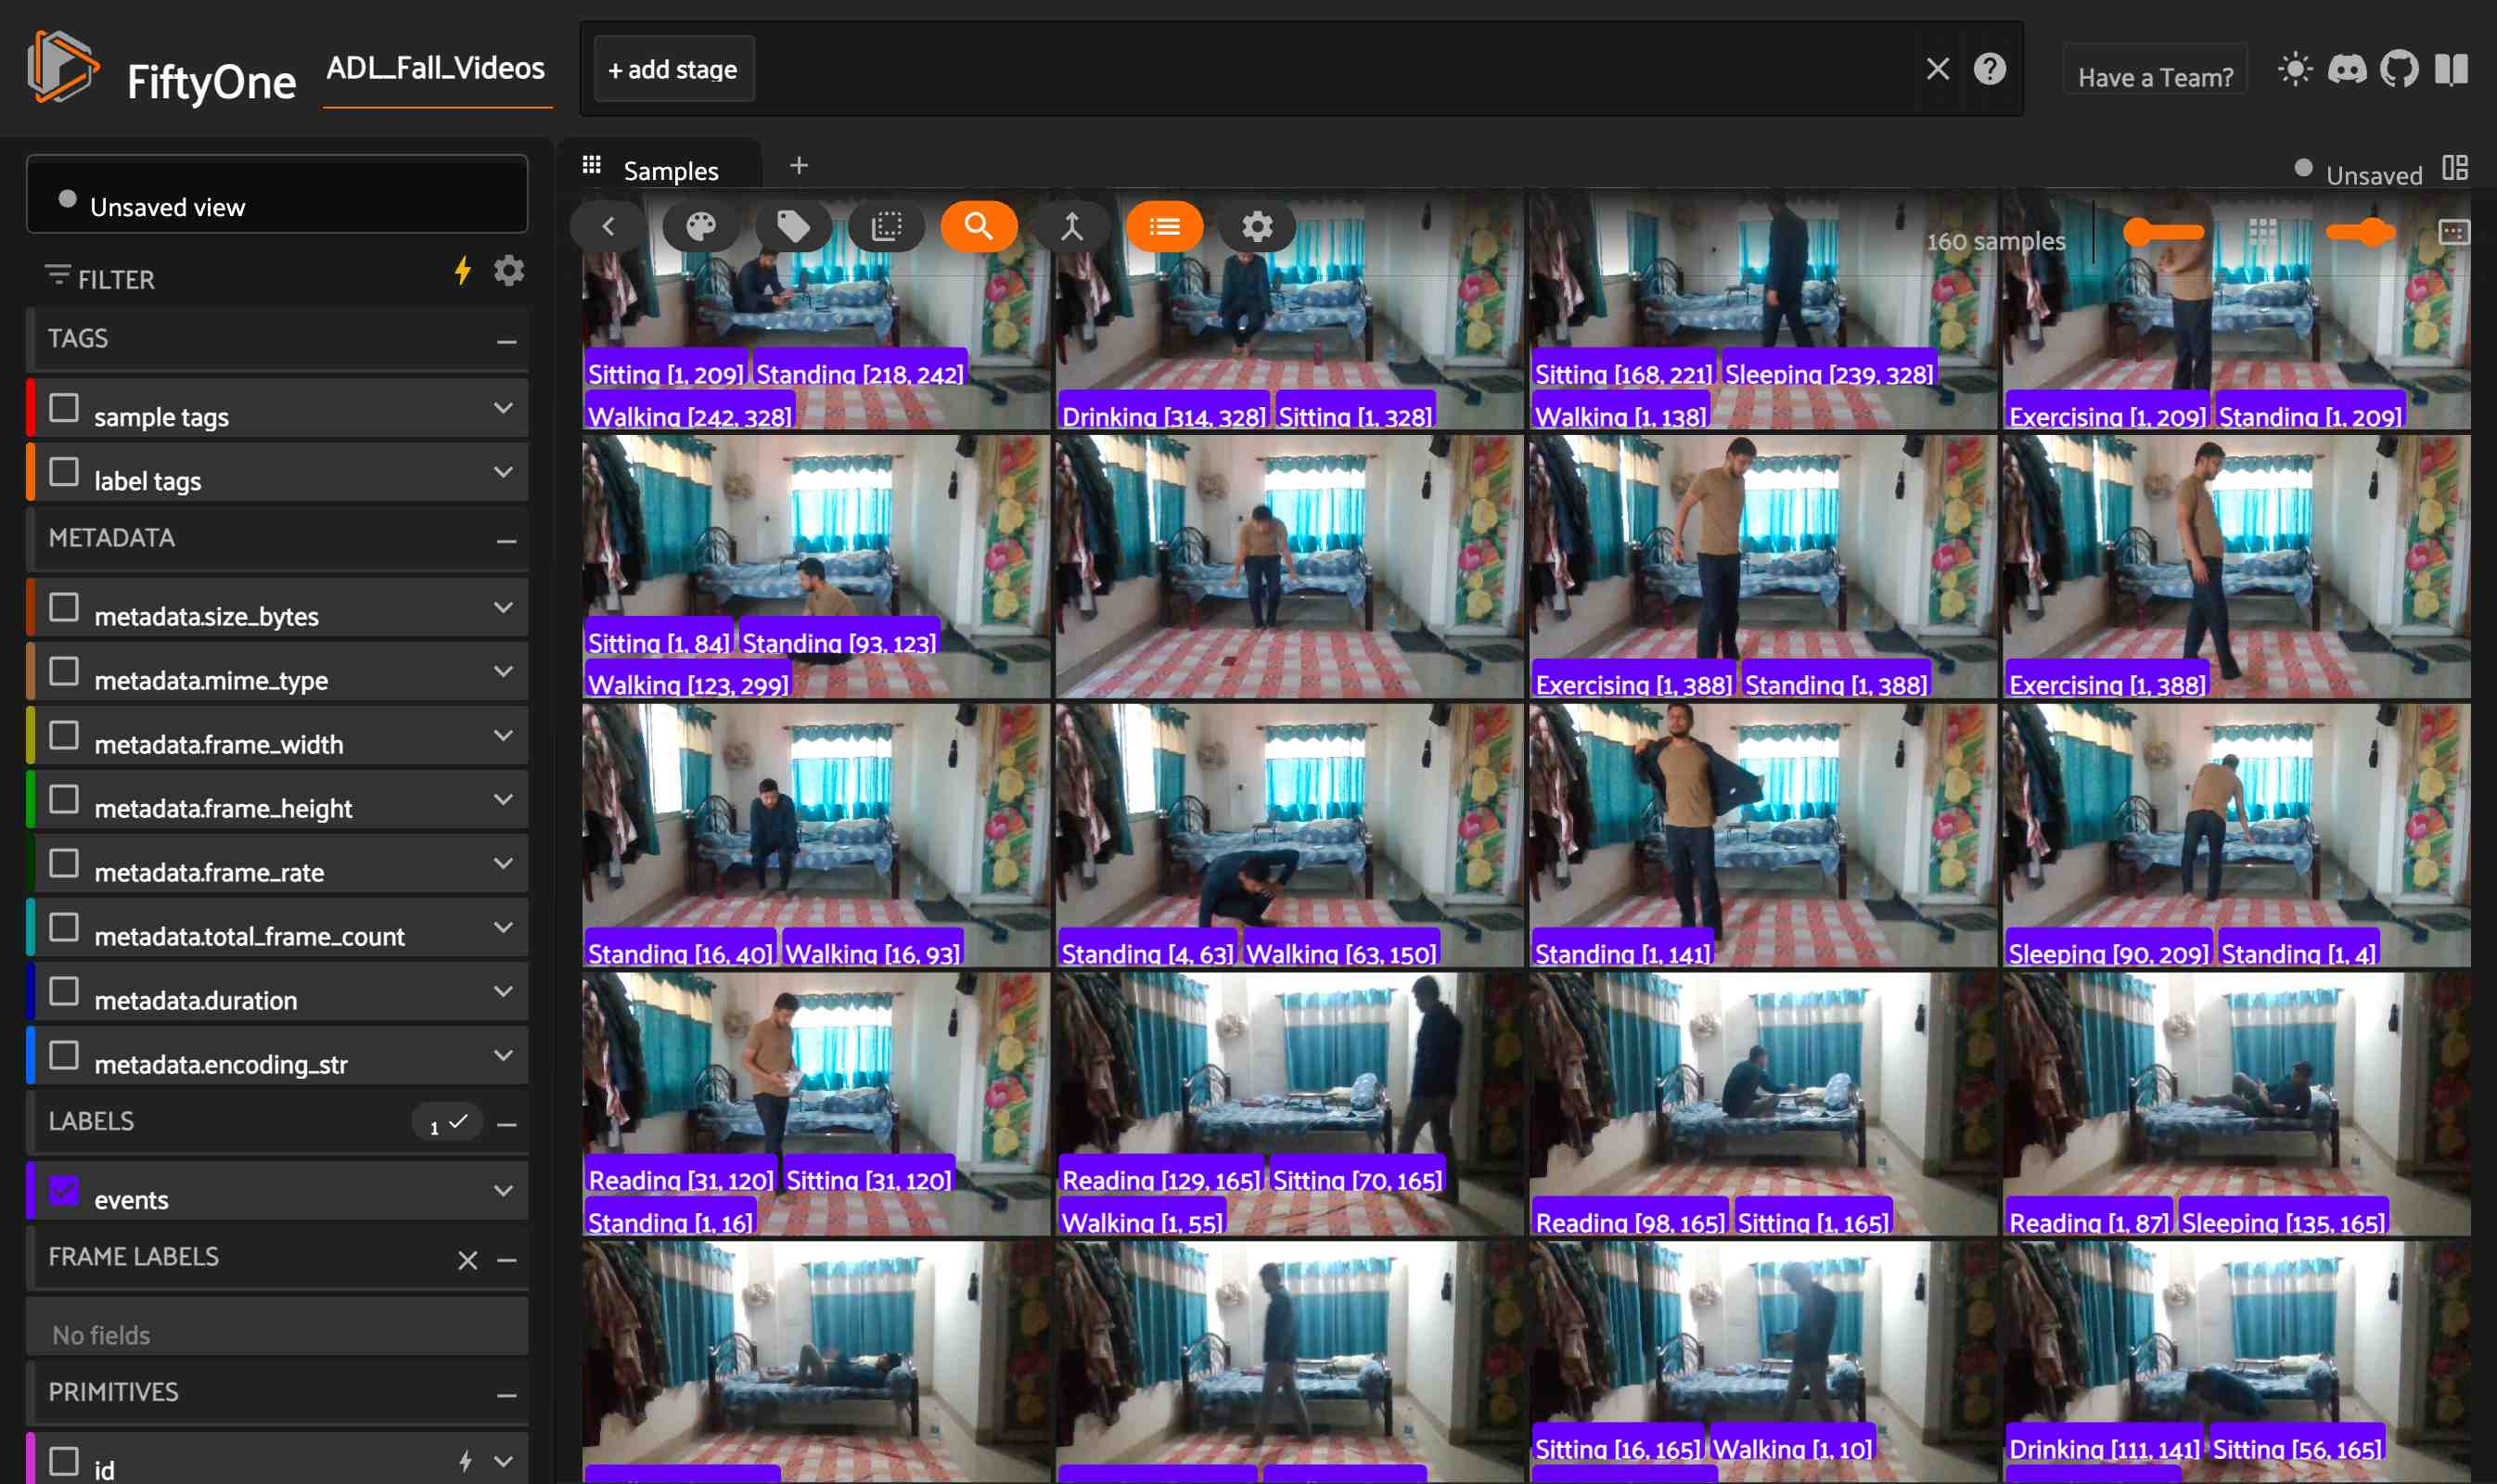

In [5]:
session = fo.launch_app(fo_dataset)

## Creating Clips based-on individual actions

Using the ```"events"``` field in each sample, you can split videos into clips based on their specific actions. The ```to_clips()``` unction in FiftyOne creates a view with one sample per clip, defined by the field or expression specified in the video collection.

More documentation can be found [here](https://docs.voxel51.com/api/fiftyone.core.clips.html?highlight=to_clip#fiftyone.core.clips.ClipsView.to_clips)

<div style="border-left: 4px solid #3498db; padding: 6px;">
<strong>Note:</strong> After running this section, check the "events" labels in the metadata menu. Clicking on each event will display the specific section of the video where the action occurs.
</div>



In [ ]:
view = fo_dataset.to_clips("events")
session.view = view
print(view)

Dataset:    ADL_Fall_Videos
Media type: video
Num clips:  335
Clip fields:
    id:               fiftyone.core.fields.ObjectIdField
    sample_id:        fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    support:          fiftyone.core.fields.FrameSupportField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.VideoMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    events:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
Frame fields:
    id:               fiftyone.core.fields.ObjectIdField
    frame_number:     fiftyone.core.fields.FrameNumberField
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
View stages:
    1. ToClips(field_or_expr='e

## Exporting Dataset into a Video Classification Directory Tree

To simplify the dataset structure, we export the GMDCSA24 Dataset as a classification dataset. The directory tree will reflect the individual labels, making it easier to train models.

Using the view created from the ```"events"``` field, we export the dataset in the```types.VideoClassificationDirectoryTree``` format. This structure is ideal for machine learning workflows.

In [7]:
view.export(
    export_dir="/path/to/the/GMDCSA24/new_folder",
    dataset_type=fo.types.VideoClassificationDirectoryTree,
)


 100% |█████████████████| 335/335 [2.5m elapsed, 0s remaining, 3.5 samples/s]      


## New dataset

Creates a new dataset containing a copy of the contents of the view.

In [8]:
new_dataset= view.clone()
print(new_dataset)

Name:        2025.01.03.09.09.28
Media type:  video
Num samples: 335
Persistent:  False
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.VideoMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    sample_id:        fiftyone.core.fields.ObjectIdField
    support:          fiftyone.core.fields.FrameSupportField
    events:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
Frame fields:
    id:               fiftyone.core.fields.ObjectIdField
    frame_number:     fiftyone.core.fields.FrameNumberField
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField


## Exporting Dataset to FiftyOneDataset

FiftyOne supports various dataset formats. In this notebook, we’ve worked with a custom dataset and added each sample manually. Now, we export it into a FiftyOne-compatible dataset to leverage additional capabilities.

For more details on the dataset types supported by FiftyOne, refer to this [documentation]](https://docs.voxel51.com/api/fiftyone.types.dataset_types.html?highlight=dataset%20type#module-fiftyone.types.dataset_types)

In [9]:
export_dir = "/path/to/the/GMDCSA24/new_folder_FO_Dataset"
new_dataset.export(
    export_dir=export_dir,
    dataset_type=fo.types.FiftyOneDataset,
)

Exporting samples...
 100% |████████████████████| 335/335 [830.3ms elapsed, 0s remaining, 403.5 docs/s]      
Exporting frames...
 100% |████████████████████████| 0/0 [185.3us elapsed, ? remaining, ? docs/s] 
